In [1]:
import io
import re
import string
import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
%load_ext tensorboard

In [3]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

## Problem 1

In [4]:
autophrase = pd.read_csv("Autophrase_multi-words.txt", header = None, sep = "\t")

In [5]:
autophrase.head()

,0,1
0,0.987922,histogram equalization
1,0.986208,point clouds
2,0.985326,krylov subspace
3,0.985084,gröbner bases
4,0.985036,random walk


In [6]:
len(autophrase)

648988

In [7]:
autophrase_100 = autophrase[autophrase[0] > 0.5].sample(100)

In [8]:
autophrase_100.to_csv("autophrase_100.txt", header=None, index=None, sep='\t', mode='a')

In [9]:
high_quality = len(autophrase_100[autophrase_100[0] > 0.9]) / len(autophrase_100)
print("The percentage of high-quality phrases:", high_quality)

The percentage of high-quality phrases: 0.2


## Problem 2

In [10]:
autophrase_100 = autophrase_100.rename(columns={0: "score", 1: "multi_phrase"})
autophrase_100['high_quality'] = autophrase_100['score'].apply(lambda x: 1 if x > 0.9 else 0)
autophrase_100.head(20)
autophrase_100["cum_sum"] = autophrase_100["high_quality"].cumsum()
autophrase_100["cum_index"] = list(range(1, len(autophrase_100)+1))
autophrase_100["recall"] = autophrase_100["cum_sum"] / autophrase_100["high_quality"].sum()
autophrase_100["precision"] = autophrase_100["cum_sum"] / autophrase_100["cum_index"]

In [11]:
autophrase_100.head()

,score,multi_phrase,high_quality,cum_sum,cum_index,recall,precision
20429,0.907193,lipschitz constants,1,1,1,0.05,1.000000
102276,0.691704,mentoring program,0,1,2,0.05,0.500000
118324,0.653160,fpga families,0,1,3,0.05,0.333333
52151,0.820009,modular forms,0,1,4,0.05,0.250000
74929,0.758956,perceptual coding,0,1,5,0.05,0.200000


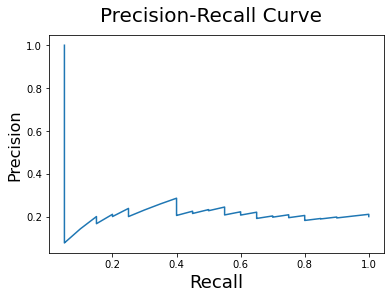

In [12]:
fig = plt.figure()
plt.plot(autophrase_100["recall"], autophrase_100["precision"])
fig.suptitle('Precision-Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=16)
fig.savefig('Precision-Recall Curve.jpg')

## Problem 3

In [13]:
with open('segmentation.txt',encoding='utf-8') as f:
    line=f.read()
def func(x):
    start,end=x.span()
    s=line[start:end]
    s=s.replace('<phrase>', '').replace('</phrase>', '').replace(' ', '_')
    return s
s = re.sub(r"<phrase>.*?</phrase>", func, line)
#print(s)
with open('adjusted_seg.txt','w',encoding='utf-8') as f:
    f.write(s)

In [14]:
text_ds = tf.data.TextLineDataset('adjusted_seg.txt').filter(lambda x: tf.cast(tf.strings.length(x), bool))

Metal device set to: Apple M1 Pro


2021-12-06 22:09:42.554777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-06 22:09:42.567444: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and number of words in a sequence.
vocab_size = 3000000
sequence_length = 30

# Use the TextVectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
vectorize_layer.adapt(text_ds.batch(1024))

2021-12-06 22:09:42.737391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-06 22:09:42.738374: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-06 22:09:42.791772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [17]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'of', 'and', 'a', 'in', 'to', 'for', 'is', 'on', 'we', 'that', 'with', 'this', 'are', 'an', 'by', 'as', 'be']


In [18]:
len(inverse_vocab)

1077247

In [19]:
inverse_vocab[-1]

'00000000'

In [20]:
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [21]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

5017534


In [22]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[695593   1382    499     13     16    399    452    932      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0] => ['oqlc', 'extending', 'c', 'with', 'an', 'object', 'query', 'capability', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[13076     6 16974     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0] => ['transactionmanagement', 'in', 'multidatabasesystems', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] => ['', '', '', '', ''

In [23]:
list_text = []
for seq in sequences:
    list_text.append([inverse_vocab[i] for i in seq])
    # print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

In [24]:
len(list_text[0])

30

In [25]:
len(list_text)

5017534

In [26]:
model = gensim.models.Word2Vec(sentences=list_text, vector_size=100, window=10, min_count=1, workers=5)

In [27]:
model.wv.similarity('booleancsp', 'booleancsp')

0.9999999

In [28]:
model.wv["gröbnerbases"]

array([ 0.044232  ,  0.59468293,  0.03954777, -0.11315122,  0.8736043 ,
        0.27728564, -0.63151157, -0.86564285, -0.35103554,  1.2561715 ,
       -0.56348807,  0.58475393,  1.0707393 , -1.3930165 ,  0.9246601 ,
       -1.2093716 ,  0.31581524, -0.9835622 ,  0.97234863, -0.07306048,
       -0.47281078, -1.4035573 ,  0.6165679 , -2.8022685 , -1.5840313 ,
        0.27495718, -0.24766168, -0.27638263,  0.76691633,  0.38374522,
        0.761939  ,  0.4981781 , -0.6936039 ,  0.83917785, -0.30008245,
        0.52937204, -0.2662985 ,  1.1131474 , -0.17972794,  1.1192292 ,
        1.817268  ,  0.42238408, -0.8570704 ,  0.7293451 ,  0.48900256,
       -0.9438362 , -0.6225963 , -0.43475977, -0.28168976, -1.1769019 ,
        0.3755075 ,  0.7030161 ,  0.09044127,  0.25245187,  0.14629926,
       -0.00505964,  0.26158407,  0.21626776,  0.4096841 , -0.08428175,
       -0.4687614 , -0.01171478,  1.1977173 ,  0.7840697 , -0.31278017,
        0.31404796,  0.01023868,  0.8144832 ,  0.12183052, -0.56

In [29]:
for index, word in enumerate(model.wv.index_to_key):
    if index > 661950 and index < 662000:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #661951/699210 is everywherefrom
word #661952/699210 is tonights
word #661953/699210 is feasibily
word #661954/699210 is accessing3
word #661955/699210 is demri
word #661956/699210 is stretchactivated
word #661957/699210 is revascularize
word #661958/699210 is n588k
word #661959/699210 is automaticimagedriven
word #661960/699210 is leftventriclesegmentation
word #661961/699210 is manuallydrawn
word #661962/699210 is 2dstrain
word #661963/699210 is ryr
word #661964/699210 is highangularresolution
word #661965/699210 is upstroke
word #661966/699210 is dvesdtmin
word #661967/699210 is dtmriderived
word #661968/699210 is adjunctive
word #661969/699210 is dyssynchronous
word #661970/699210 is distinguing
word #661971/699210 is backwardreachability
word #661972/699210 is somad
word #661973/699210 is hypertrapeze
word #661974/699210 is bmus
word #661975/699210 is scuttling
word #661976/699210 is encircled
word #661977/699210 is olognr
word #661978/699210 is ub¿
word #661979/699210 is ski

## Problem 4

In [30]:
autophrase_compare = autophrase[autophrase[0] > 0.5]
autophrase_compare

,0,1
0,0.987922,histogram equalization
1,0.986208,point clouds
2,0.985326,krylov subspace
3,0.985084,gröbner bases
4,0.985036,random walk
...,...,...
188770,0.500011,random 3 cnf
188771,0.500011,local effect
188772,0.500009,power reduction techniques
188773,0.500006,incremental bayesian


In [31]:
high_quality3 = autophrase_100[autophrase_100["score"] > 0.9].sample(3)
high_quality3

,score,multi_phrase,high_quality,cum_sum,cum_index,recall,precision
20967,0.905698,shock tube,1,3,15,0.15,0.200000
3341,0.962626,electre tri,1,10,43,0.50,0.232558
15725,0.920832,developable surfaces,1,14,69,0.70,0.202899


In [32]:
# def remove(string):
#     pattern = re.compile(r'\s+')
#     return re.sub(pattern, '', string)
def remove(string):
    return string.replace(" ", "").replace("'","")

In [33]:
autophrase_compare[1] = autophrase_compare[1].apply(remove)

/var/folders/h5/xy66q_8n5m91xb6gg__86s3c0000gn/T/ipykernel_14423/2084114306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autophrase_compare[1] = autophrase_compare[1].apply(remove)


In [34]:
autophrase_compare

,0,1
0,0.987922,histogramequalization
1,0.986208,pointclouds
2,0.985326,krylovsubspace
3,0.985084,gröbnerbases
4,0.985036,randomwalk
...,...,...
188770,0.500011,random3cnf
188771,0.500011,localeffect
188772,0.500009,powerreductiontechniques
188773,0.500006,incrementalbayesian


In [35]:
def insert_value_camassaholm(x):
    try:
        output = model.wv.similarity(x, 'camassaholm')
    except KeyError:
        return 0
    else:
        return output
    
    
def insert_value_assignment_problem(x):
    try:
        output = model.wv.similarity(x, 'assignmentproblem')
    except KeyError:
        return 0
    else:
        return output
    
def insert_value_uwb_receiver(x):
    try:
        output = model.wv.similarity(x, 'uwbreceiver')
    except KeyError:
        return 0
    else:
        return output

In [36]:
autophrase_compare["sim_camassa_holm"] = autophrase_compare[1].apply(insert_value_camassaholm)
autophrase_compare["sim_assignment_problem"] = autophrase_compare[1].apply(insert_value_assignment_problem)
autophrase_compare["sim_uwb_receiver"] = autophrase_compare[1].apply(insert_value_uwb_receiver)

/var/folders/h5/xy66q_8n5m91xb6gg__86s3c0000gn/T/ipykernel_14423/997667014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autophrase_compare["sim_camassa_holm"] = autophrase_compare[1].apply(insert_value_camassaholm)
/var/folders/h5/xy66q_8n5m91xb6gg__86s3c0000gn/T/ipykernel_14423/997667014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autophrase_compare["sim_assignment_problem"] = autophrase_compare[1].apply(insert_value_assignment_problem)
/var/folders/h5/xy66q_8n5m91xb6gg__86s3c0000gn/T/ipyker

In [37]:
autophrase_compare.head()

,0,1,sim_camassa_holm,sim_assignment_problem,sim_uwb_receiver
0,0.987922,histogramequalization,0.260632,0.138916,0.208745
1,0.986208,pointclouds,0.161483,0.118440,0.142517
2,0.985326,krylovsubspace,0.515203,0.242082,0.514864
3,0.985084,gröbnerbases,0.497932,0.132676,0.296090
4,0.985036,randomwalk,0.228044,0.324549,0.151715


In [38]:
autophrase_compare.sort_values(by=['sim_camassa_holm'], ascending = False)[:5][[0,1,"sim_camassa_holm"]].rename(columns={0: "score", 1: "multi_phrase"})

,score,multi_phrase,sim_camassa_holm
21642,0.903728,camassaholm,1.000000
66536,0.780643,neutraldelay,0.776966
13611,0.927007,petrovgalerkin,0.776936
96522,0.705536,kortewegdevries,0.776004
23172,0.899161,advectiondiffusionreaction,0.774089


In [39]:
autophrase_compare.sort_values(by=['sim_assignment_problem'], ascending = False)[:5][[0,1,"sim_assignment_problem"]].rename(columns={0: "score", 1: "multi_phrase"})

,score,multi_phrase,sim_assignment_problem
11575,0.933178,assignmentproblem,1.000000
55308,0.810978,routingproblem,0.850013
1051,0.972496,travelingsalesmanproblem,0.841239
8809,0.942131,vehicleroutingproblem,0.837479
37205,0.861418,shortestpathproblem,0.835289


In [40]:
autophrase_compare.sort_values(by=['sim_uwb_receiver'], ascending = False)[:5][[0,1,"sim_uwb_receiver"]].rename(columns={0: "score", 1: "multi_phrase"})

,score,multi_phrase,sim_uwb_receiver
10506,0.936644,uwbreceiver,1.000000
1007,0.972721,operationaltransconductanceamplifier,0.802967
10821,0.935711,directdigitalfrequencysynthesizer,0.790353
17270,0.916302,lcoscillator,0.788645
30772,0.878331,classdaudioamplifier,0.788376


In [41]:
autophrase_compare[autophrase_compare["sim_uwb_receiver"] == 0]

,0,1,sim_camassa_holm,sim_assignment_problem,sim_uwb_receiver
70,0.981340,riverbasin,0.0,0.0,0.0
76,0.981038,δςmodulator,0.0,0.0,0.0
80,0.980983,orthopaedicsurgery,0.0,0.0,0.0
100,0.980593,biochemicalpathways,0.0,0.0,0.0
105,0.980501,softtissues,0.0,0.0,0.0
...,...,...,...,...,...
188768,0.500015,camarchitecture,0.0,0.0,0.0
188769,0.500014,scalingandtranslation,0.0,0.0,0.0
188772,0.500009,powerreductiontechniques,0.0,0.0,0.0
188773,0.500006,incrementalbayesian,0.0,0.0,0.0
